In [1]:
import random
import os
import shutil

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.datasets as dsets
import torchvision

from scipy.ndimage.filters import gaussian_filter
import PIL
from PIL import Image

random.seed(42)

In [2]:
class resBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, k=3, s=1, p=1):
        super(resBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, k, stride=s, padding=p)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, k, stride=s, padding=p)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        return self.bn2(self.conv2(y)) + x
    
class resTransposeBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, k=3, s=1, p=1):
        super(resTransposeBlock, self).__init__()

        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, k, stride=s, padding=p)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, k, stride=s, padding=p)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        return self.bn2(self.conv2(y)) + x
    
class VGG19_extractor(nn.Module):
    def __init__(self, cnn):
        super(VGG19_extractor, self).__init__()
        self.features1 = nn.Sequential(*list(cnn.features.children())[:3])
        self.features2 = nn.Sequential(*list(cnn.features.children())[:5])
        self.features3 = nn.Sequential(*list(cnn.features.children())[:12])
    def forward(self, x):
        return self.features1(x), self.features2(x), self.features3(x)

In [3]:
vgg19_exc = VGG19_extractor(torchvision.models.vgg19(pretrained=True))
vgg19_exc = vgg19_exc.cuda()

### Designing Encoder (E)

In [4]:
class Encoder(nn.Module):
    def __init__(self, n_res_blocks=5):
        super(Encoder, self).__init__()
        self.n_res_blocks = n_res_blocks
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_1' + str(i+1), resBlock(in_channels=64, out_channels=64, k=3, s=1, p=1))
        self.conv2 = nn.Conv2d(64, 32, 3, stride=2, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_2' + str(i+1), resBlock(in_channels=32, out_channels=32, k=3, s=1, p=1))
        self.conv3 = nn.Conv2d(32, 8, 3, stride=1, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_3' + str(i+1), resBlock(in_channels=8, out_channels=8, k=3, s=1, p=1))
        self.conv4 = nn.Conv2d(8, 1, 3, stride=1, padding=1)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_1'+str(i+1))(y))
        y = F.relu(self.conv2(y))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_2'+str(i+1))(y))
        y = F.relu(self.conv3(y))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_3'+str(i+1))(y))
        y = self.conv4(y)
        return y

E1 = Encoder(n_res_blocks=10)

### Designing Decoder (D)

In [5]:
class Decoder(nn.Module):
    def __init__(self, n_res_blocks=5):
        super(Decoder, self).__init__()
        self.n_res_blocks = n_res_blocks
        self.conv1 = nn.ConvTranspose2d(1, 8, 3, stride=1, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_1' + str(i+1), resTransposeBlock(in_channels=8, out_channels=8, k=3, s=1, p=1))
        self.conv2 = nn.ConvTranspose2d(8, 32, 3, stride=1, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_2' + str(i+1), resTransposeBlock(in_channels=32, out_channels=32, k=3, s=1, p=1))
        self.conv3 = nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1)
        for i in range(n_res_blocks):
            self.add_module('residual_block_3' + str(i+1), resTransposeBlock(in_channels=64, out_channels=64, k=3, s=1, p=1))
        self.conv4 = nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_1'+str(i+1))(y))
        y = F.relu(self.conv2(y))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_2'+str(i+1))(y))
        y = F.relu(self.conv3(y))
        for i in range(self.n_res_blocks):
            y = F.relu(self.__getattr__('residual_block_3'+str(i+1))(y))
        y = self.conv4(y)
        return y

D1 = Decoder(n_res_blocks=10)

### Putting it in box, VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.E = encoder
        self.D = decoder
        self._enc_mu = nn.Linear(11*11, 128)
        self._enc_log_sigma = nn.Linear(11*11, 128)
        self._din_layer = nn.Linear(128, 11*11)
        
    def _sample_latent(self, h_enc):
        '''
        Return the latent normal sample z ~ N(mu, sigma^2)
        '''
        mu = self._enc_mu(h_enc)
#         print('mu size : ', mu.size())
        log_sigma = self._enc_log_sigma(h_enc)
#         print('log_sigma size : ', log_sigma.size())
        sigma = torch.exp(log_sigma)
#         print('sigma size : ', sigma.size())
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma
        
        return mu + sigma * Variable(std_z, requires_grad=False).cuda()  # Reparameterization trick

    def forward(self, x):
        n_bacth = x.size()[0]
        h_enc = self.E(x)
        indim1_D, indim2_D = h_enc.size()[2], h_enc.size()[3] 
#         print('h_enc size : ', h_enc.size())
        h_enc = h_enc.view(n_bacth, 1, -1)
#         print('h_enc size : ', h_enc.size())
        z = self._sample_latent(h_enc)
#         print('z_size : ', z.size())
        z = self._din_layer(z)
#         print('z_size : ', z.size())
        z = z.view(n_bacth, 1, indim1_D, indim2_D)
#         print('z_size : ', z.size())
#         print('Dz_size : ', self.D(z).size())
        return self.D(z)

In [ ]:
V = VAE(E1, D1)
V = V.cuda()

In [12]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.E = encoder
        self.D = decoder
    def forward(self, x):
        h_enc = self.E(x)
#         print('encoder out checking for nan ', np.isnan(h_enc.data.cpu()).any())
        y = self.D(h_enc)
#         print('decoder out checking for nan ', np.isnan(y.data.cpu()).any())
        return y

In [13]:
A = AE(E1, D1)
A = A.cuda()

### Dataloading and stuff

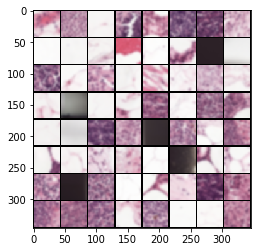

Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/udion/anaco

In [8]:
mytransform1 = transforms.Compose(
    [transforms.RandomCrop((41,41)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def mynorm2(x):
    m1 = torch.min(x)
    m2 = torch.max(x)
    return (x-m1)/(m2-m1)

mytransform2 = transforms.Compose(
    [transforms.RandomCrop((246,246)),
     transforms.Lambda( lambda x : Image.fromarray(gaussian_filter(x, sigma=(10,10,0)) )),
     transforms.Resize((41,41)),
     transforms.ToTensor(),
     transforms.Lambda( lambda x : x)])

trainset = dsets.ImageFolder(root='../sample_dataset/train/',transform=mytransform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = dsets.ImageFolder(root='../sample_dataset/test/',transform=mytransform2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)
# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def imshow2(img):
    m1 = torch.min(img)
    m2 = torch.max(img)
    img = (img-m1)/(m2-m1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #all the images under the same 'unlabeled' folder
# print(labels)
# show images
imshow(torchvision.utils.make_grid(images))

### training thingy

In [ ]:
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

In [ ]:
def save_model(model, model_name):
    try:
        os.makedirs('../saved_models')
    except OSError:
        pass
    torch.save(model.state_dict(), '../saved_models/'+model_name)
    print('model saved at '+'../saved_models/'+model_name)

In [9]:
# dataloader = iter(trainloader)
testiter = iter(testloader)
testX, _ = next(testiter)
def eval_model(model):
    X = testX
    print('input looks like ...')
    plt.figure()
    imshow(torchvision.utils.make_grid(X))
    
    X = Variable(X).cuda()
    Y = model(X)
    print('output looks like ...')
    plt.figure()
    imshow2(torchvision.utils.make_grid(Y.data.cpu()))

Process Process-3:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/udion/anaconda3/envs/DeepCV3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/udion/anac

In [ ]:
def train(model, rec_interval=2, disp_interval=20, eval_interval=1):
    nepoch = 500
    Criterion1 = nn.MSELoss()
    Criterion2 = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    loss_track = []
    for eph in range(nepoch):
        dataloader = iter(trainloader)
        print('starting epoch {} ...'.format(eph))
        for i, (X, _) in enumerate(dataloader):
            X = Variable(X).cuda()
            optimizer.zero_grad()
            reconX = model(X)
#             KLTerm = latent_loss(model.z_mean, model.z_sigma)
            reconTerm = Criterion1(reconX, X) + Criterion2(reconX, X)
#             loss = reconTerm + 100*KLTerm
            loss =reconTerm
            loss.backward()
            optimizer.step()
            
            if i%rec_interval == 0:
                loss_track.append(loss.data[0])
            if i%disp_interval == 0:
#                 print('epoch : {}, iter : {}, KLterm : {}, reconTerm : {}, totalLoss : {}'.format(eph, i, KLTerm.data[0], reconTerm.data[0], loss.data[0]))
                print('epoch : {}, iter : {}, reconTerm : {}, totalLoss : {}'.format(eph, i, reconTerm.data[0], loss.data[0]))
#         if eph%eval_interval == 0:
#             print('after epoch {} ...'.format(eph))
#             eval_model(model)
        
    return loss_track

In [10]:
def train_ae(model, rec_interval=2, disp_interval=20, eval_interval=1):
    nepoch = 3
    Criterion2 = nn.MSELoss()
    Criterion1 = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    loss_track = []
    for eph in range(nepoch):
        dataloader = iter(trainloader)
        print('starting epoch {} ...'.format(eph))
        for i, (X, _) in enumerate(dataloader):
            X = Variable(X).cuda()
            optimizer.zero_grad()
            reconX = model(X)
            l2 = Criterion2(reconX, X)
#             l1 = Criterion1(reconX, X)
            
            t1, t2, t3 = vgg19_exc(X)
            rt1, rt2, rt3 = vgg19_exc(reconX)
            
#             t1 = Variable(t1.data)
#             rt1 = Variable(rt1.data)
#             t2 = Variable(t2.data)
#             rt2 = Variable(rt2.data)
            t3 = Variable(t3.data)
            rt3 = Variable(rt3.data)
            
#             vl1 = Criterion2(rt1, t1)
#             vl2 = Criterion2(rt2, t2)
            vl3 = Criterion2(rt3, t3)
            
            reconTerm = 10*l2 + vl3
            loss = reconTerm
            loss.backward()
            optimizer.step()
            
            if i%rec_interval == 0:
                loss_track.append(loss.data[0])
            if i%disp_interval == 0:
                print('epoch: {}, iter: {}, L2term: {},  vl3: {}, totalLoss: {}'.format(
                    eph, i, l2.data[0], vl3.data[0], loss.data[0]))
    return loss_track

#### Notes on training
It seems like the combination of L1 and L2 loss is not helping and also the features from deeper layers from VGG19 are more effective than the features on the shallow leve

In [11]:
loss_track = train_ae(A, disp_interval=10)

starting epoch 0 ...
encoder out checking for nan  False
decoder out checking for nan  False
epoch: 0, iter: 0, L2term: 0.8983635306358337,  vl3: 7.830014228820801, totalLoss: 16.813648223876953
encoder out checking for nan  False
decoder out checking for nan  False
encoder out checking for nan  False
decoder out checking for nan  False
encoder out checking for nan  False
decoder out checking for nan  False
encoder out checking for nan  False
decoder out checking for nan  False
encoder out checking for nan  False
decoder out checking for nan  False
encoder out checking for nan  False
decoder out checking for nan  False
encoder out checking for nan  False
decoder out checking for nan  False
encoder out checking for nan  False
decoder out checking for nan  False
encoder out checking for nan  False
decoder out checking for nan  False
encoder out checking for nan  False
decoder out checking for nan  False
epoch: 0, iter: 10, L2term: 0.9259738326072693,  vl3: 7.311758041381836, totalLoss: 1

In [ ]:
plt.plot(loss_track)

In [ ]:
eval_model(A)

In [ ]:
save_model(A, 'AE_VGGFeatX1.pth')

#### experiments with the sigmoid and BCE

In [ ]:
class AE1(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE1, self).__init__()
        self.E = encoder
        self.D = decoder
    def forward(self, x):
        h_enc = self.E(x)
        return F.relu(self.D(h_enc))

In [ ]:
A1 = AE1(E1, D1)
A1 = A1.cuda()

In [ ]:
def train_ae_logsmax(model, rec_interval=2, disp_interval=20, eval_interval=1):
    nepoch = 250
    Criterion2 = nn.MSELoss()
    Criterion1 = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=2*1e-5)
    loss_track = []
    for eph in range(nepoch):
        dataloader = iter(trainloader)
        print('starting epoch {} ...'.format(eph))
        for i, (X, _) in enumerate(dataloader):
            X = Variable(X).cuda()
            optimizer.zero_grad()
            reconX = model(X)
            l2 = Criterion2(reconX, X)
#             l1 = Criterion1(reconX, X)
            
            t1, t2, t3 = vgg19_exc(X)
            rt1, rt2, rt3 = vgg19_exc(reconX)
            
#             t1 = Variable(t1.data)
#             rt1 = Variable(rt1.data)
#             t2 = Variable(t2.data)
#             rt2 = Variable(rt2.data)
            t3 = Variable(t3.data)
            rt3 = Variable(rt3.data)
            
#             vl1 = Criterion2(rt1, t1)
#             vl2 = Criterion2(rt2, t2)
            vl3 = Criterion2(rt3, t3)
            
            reconTerm = 10*l2 + vl3
            loss = reconTerm
            loss.backward()
            optimizer.step()
            
            if i%rec_interval == 0:
                loss_track.append(loss.data[0])
            if i%disp_interval == 0:
                print('epoch: {}, iter: {}, L2term: {},  vl3: {}, totalLoss: {}'.format(
                    eph, i, l2.data[0], vl3.data[0], loss.data[0]))
    return loss_track

In [ ]:
loss_track1 = train_ae_logsmax(A1, disp_interval=100)

In [ ]:
plt.plot(loss_track1)

In [ ]:
eval_model(A1)